In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchvision import utils, datasets, transforms

import time
import scipy
import sys
import os
import shutil
import random


In [2]:
faces_dir_original = './datasets/att_faces'
faces_dir_compress = './datasets/att_faces_compress'
faces_dir_restore = './datasets/att_faces_restore'


In [3]:
def compress_faces():													# *** COMMENTS ***
	faces_count = 40  
	imgs_compressed = []                                                        # directory path to the AT&T faces                                                                 # length of the column vector

	print('> Initializing started')

	faces_dir = './datasets/att_faces'
	# compress_dir = './datasets/att_faces_compress'
	training_ids = []                                                  # train image id's for every at&t face

	cur_img = 0
	for face_id in range(1, faces_count + 1):
		print(face_id)
		training_ids = range(1, 11)
		for training_id in training_ids:
			path_to_img = os.path.join(faces_dir,
					's' + str(face_id), str(training_id) + '.pgm')          # relative path
			print('> reading file: ' + path_to_img)
			img = cv2.imread(path_to_img, 0)                                # read a grayscale image
			img_data = torch.from_numpy(img.astype(np.float32)).unsqueeze(0)
			img_data = img_data.unsqueeze(0)/255  #shape [batch, C, H, W]
			img_data = img_data*2 - 1 # normalize to [-1, 1]

			B, C, H, W = img_data.shape # data: shape [batch, 3, H, W] where 3 means RGB channels, batch=10, H=W=32

			compressed_img = torch.nn.functional.interpolate(img_data, scale_factor=0.5, mode='bilinear')
			X_data = torch.nn.functional.interpolate(compressed_img, scale_factor=2, mode='nearest')
			X_data = torch.clamp(X_data[0].squeeze(0), min=-1.0, max=1.0)
			X_data = X_data / 2 + 0.5
			X_data_np = X_data.cpu().data.numpy()
			print('> downsample using bilinear interpolation: ' + str(compressed_img.shape))
			print('> upsample using nearest interpolation: ' + str(X_data.shape))
			print('> saving compressed np array: ' + str(X_data_np.shape))
			path_to_compress = os.path.join(faces_dir_compress,
					's' + str(face_id), str(training_id) + '.npy')          # relative path
			path_to_ori = os.path.join(faces_dir,
		's' + str(face_id), str(training_id) + '.npy')          # relative path
			np.save(path_to_ori, img)
			np.save(path_to_compress, X_data_np)
			
			imgs_compressed.append(X_data_np)
	imgs_compressed = np.array(imgs_compressed)
	return imgs_compressed
		


In [4]:
imgs_compressed = compress_faces() #compress first, then interpolate using nearest, will be used as X

> Initializing started
1
> reading file: ./datasets/att_faces/s1/1.pgm
> downsample using bilinear interpolation: torch.Size([1, 1, 56, 46])
> upsample using nearest interpolation: torch.Size([112, 92])
> saving compressed np array: (112, 92)
> reading file: ./datasets/att_faces/s1/2.pgm
> downsample using bilinear interpolation: torch.Size([1, 1, 56, 46])
> upsample using nearest interpolation: torch.Size([112, 92])
> saving compressed np array: (112, 92)
> reading file: ./datasets/att_faces/s1/3.pgm
> downsample using bilinear interpolation: torch.Size([1, 1, 56, 46])
> upsample using nearest interpolation: torch.Size([112, 92])
> saving compressed np array: (112, 92)
> reading file: ./datasets/att_faces/s1/4.pgm
> downsample using bilinear interpolation: torch.Size([1, 1, 56, 46])
> upsample using nearest interpolation: torch.Size([112, 92])
> saving compressed np array: (112, 92)
> reading file: ./datasets/att_faces/s1/5.pgm
> downsample using bilinear interpolation: torch.Size([1,

In [5]:
def plot_one_image(img):
    # plt.imshow('image window', img)
    # plt.imshow(img.cpu().data.numpy())
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

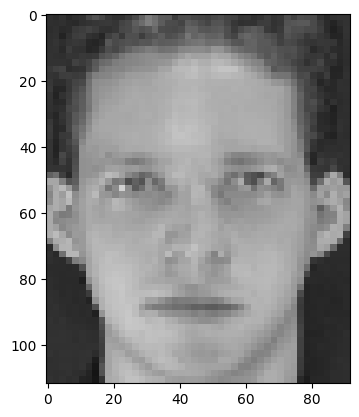

In [6]:
plot_one_image(imgs_compressed[0])

In [7]:
def STEM(inputs, channel=3):
    '''
    return: stem features with shape [batchxHxW, 3xkernelxkernel] where batch=10, H=W=32, kernel=3
    '''
    kernel = 3
    B, C, H, W = inputs.shape
    X = []
    inputs_with_padding = torch.cat((inputs,torch.zeros((B,C,H,kernel))),-1)
    inputs_with_padding = torch.cat((inputs_with_padding,torch.zeros(B,C,kernel,W+kernel)),-2)
    for i in range(inputs.shape[2]):
        row = []
        for j in range(inputs.shape[3]):
            row.append(inputs_with_padding[:,:,i:i+kernel,j:j+kernel])
        X.append(row)
    X = torch.stack([torch.stack(x,2) for x in X],2).permute(0,2,3,1,4,5)
    return X.reshape(-1,channel*kernel*kernel)

In [8]:
def DPCA_eig(Y, X, m): #here we minimize $\| Y - F U X \|^2$
    # Y: (3,BHW), X: (27, BHW)
    n,p = X.size()
    XYt = torch.mm(X, Y.t())
    RM = torch.mm(torch.inverse(torch.mm(X, X.t())+1e-3*torch.eye(X.shape[0])),
			        torch.mm(XYt, XYt.t()))
    eigenvalues, eigenvectors = torch.linalg.eig(RM)
    
    values, indices = torch.sort(eigenvalues.real, descending=True)
    
    U = (eigenvectors[:, indices[:m]]).t().real  #(m,27)
    explained_variance = values[:m]
    UX = torch.mm(U,X)
    F = torch.mm(torch.mm(Y, UX.t()),
                 torch.inverse(torch.mm(UX, UX.t())+1e-3*torch.eye(UX.shape[0])),
			        )
    W = torch.mm(F, U)   #W = FU is a rank-m matrix
    return { 'X':X, 'k':m, 'components':U, 'explained_variance':explained_variance,
            'W': W}

In [9]:
def CPCA(data, targets, num_components, channel=3):
    stem = STEM(data, channel=channel)  #(BHW,27)
    PCA_output = DPCA_eig(targets, stem.t(), m=num_components) # m is number of components
    # components = PCA_output['components']
    weights = PCA_output['W']
    return stem, weights

In [10]:
def run_faces(img):
    # load babyface image
    # img = Image.open('results/baby_mini_d3_gaussian.jpg')
    # img_data = torch.from_numpy(np.asarray(img).astype(np.float32))
    img_data = torch.from_numpy(img.astype(np.float32)).unsqueeze(0)
    img_data = img_data.unsqueeze(0)/255  #shape [batch, C, H, W]
    img_data = img_data*2 - 1 # normalize to [-1, 1]

    B, C, H, W = img_data.shape # data: shape [batch, 3, H, W] where 3 means RGB channels, batch=10, H=W=32

    compressed_img = torch.nn.functional.interpolate(img_data, scale_factor=0.5, mode='bilinear')
    X_data = torch.nn.functional.interpolate(compressed_img, scale_factor=2, mode='nearest')

    targets = img_data.permute(0,2,3,1).reshape(-1, C).float().t() # (1, 112*92)
    stem, weights = CPCA(X_data, targets, 1, channel=1) #(112*92,9), (1,9)
    featuremaps = torch.matmul(weights, stem.t()).reshape(B, H, W)

    restored_img = torch.clamp(featuremaps[0].squeeze(0), min=-1.0, max=1.0)
    restored_img = restored_img / 2 + 0.5
    return restored_img.cpu().data.numpy()

In [11]:
def restore_faces():													# *** COMMENTS ***
	faces_count = 40                                                          # directory path to the AT&T faces                                                      # number of faces used for training
	print('> Initializing started')

	faces_dir = './datasets/att_faces'
	imgs_restore = []
	training_ids = []                                                  # train image id's for every at&t face


	cur_img = 0
	for face_id in range(1, faces_count + 1):
		print(face_id)
		training_ids = range(1, 11)
		for training_id in training_ids:
			path_to_img = os.path.join(faces_dir,
					's' + str(face_id), str(training_id) + '.pgm')          # relative path
			print('> reading file: ' + path_to_img)
			img = cv2.imread(path_to_img, 0)                                # read a grayscale image
			img_restore = run_faces(img)
			print('> restoring by deepPCA (w=3): ' + str(img_restore.shape))
			print('> saving restored np array: ' + str(img_restore.shape))
			path_to_restore_npy = os.path.join(faces_dir_restore,
					's' + str(face_id), str(training_id) + '.npy')
			np.save(path_to_restore_npy, img_restore)
			imgs_restore.append(img_restore)
	imgs_restore = np.array(imgs_restore)
	return imgs_restore

In [12]:
imgs_restore = restore_faces()

> Initializing started
1
> reading file: ./datasets/att_faces/s1/1.pgm
> restoring by deepPCA (w=3): (112, 92)
> saving restored np array: (112, 92)
> reading file: ./datasets/att_faces/s1/2.pgm
> restoring by deepPCA (w=3): (112, 92)
> saving restored np array: (112, 92)
> reading file: ./datasets/att_faces/s1/3.pgm
> restoring by deepPCA (w=3): (112, 92)
> saving restored np array: (112, 92)
> reading file: ./datasets/att_faces/s1/4.pgm
> restoring by deepPCA (w=3): (112, 92)
> saving restored np array: (112, 92)
> reading file: ./datasets/att_faces/s1/5.pgm
> restoring by deepPCA (w=3): (112, 92)
> saving restored np array: (112, 92)
> reading file: ./datasets/att_faces/s1/6.pgm
> restoring by deepPCA (w=3): (112, 92)
> saving restored np array: (112, 92)
> reading file: ./datasets/att_faces/s1/7.pgm
> restoring by deepPCA (w=3): (112, 92)
> saving restored np array: (112, 92)
> reading file: ./datasets/att_faces/s1/8.pgm
> restoring by deepPCA (w=3): (112, 92)
> saving restored np 

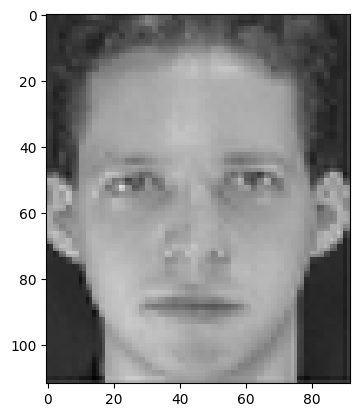

In [13]:
plot_one_image(imgs_restore[0])

# Train

In [34]:
class Eigenfaces(object):                                                       # *** COMMENTS ***
    faces_count = 40

    faces_dir = '.'                                                             # directory path to the AT&T faces

    train_faces_count = 6                                                       # number of faces used for training
    test_faces_count = 4                                                       # number of faces used for testing

    l = train_faces_count * faces_count                                         # training images count
    m = 92                                                                      # number of columns of the image
    n = 112                                                                     # number of rows of the image
    mn = m * n                                                                  # length of the column vector

    """
    Initializing the Eigenfaces model.
    """

    def __init__(self,_faces_dir = '.'):
        print('> Initializing started')

        self.faces_dir = _faces_dir
        self.energy = 0.85
        self.training_ids = []                                                  # train image id's for every at&t face

        L = np.empty(shape=(self.mn, self.l), dtype='float64')                  # each row of L represents one train image

        cur_img = 0
        for face_id in range(1, self.faces_count + 1):

            training_ids = random.sample(range(1, 11), self.train_faces_count)  # the id's of the 6 random training images
            self.training_ids.append(training_ids)                              # remembering the training id's for later

            for training_id in training_ids:
                path_to_img = os.path.join(self.faces_dir,
                        's' + str(face_id), str(training_id) + '.npy')          # relative path
                # print '> reading file: ' + path_to_img
                img = np.load(path_to_img)
                # img = cv2.imread(path_to_img, 0) 
                #                               # read a grayscale image
                # if face_id < 2 and training_id<3:
                #     plot_one_image(img)
                img_col = np.array(img, dtype='float64').flatten()              # flatten the 2d image into 1d

                L[:, cur_img] = img_col[:]                                      # set the cur_img-th column to the current training image
                cur_img += 1

        self.mean_img_col = np.sum(L, axis=1) / self.l                          # get the mean of all images / over the rows of L

        for j in range(0, self.l):                                             # subtract from all training images
            L[:, j] -= self.mean_img_col[:]

        C = np.matrix(L.transpose()) * np.matrix(L)                             # instead of computing the covariance matrix as
        C /= self.l                                                             # L*L^T, we set C = L^T*L, and end up with way
                                                                                # smaller and computentionally inexpensive one
                                                                                # we also need to divide by the number of training
        # data = torch.from_numpy(np.matrix(L.transpose())).reshape(self.l, 92, 112).unsqueeze(1)   #[320, 1, 92, 112]
        # stem = STEM(data, channel=1)  #[3297280, 9]
        # X = stem.reshape(self.l, 92*112, 9).reshape(self.l,-1).t()  #[HW9, 320]
        # Y = torch.from_numpy(np.matrix(L))                                 #[HW, 320]
        
        # XYt = torch.mm(X, Y.t())
        # # RM = torch.mm(torch.inverse(torch.mm(X, X.t())+1e-3*torch.eye(X.shape[0])),
        # #                 torch.mm(XYt, XYt.t()))
        # RM_ = torch.mm(X.t(),torch.inverse(torch.mm(X, X.t())+1e-3*torch.eye(X.shape[0])),
        #                 torch.mm(XYt, Y))
        # eigenvalues, eigenvectors = torch.linalg.eig(RM_)
        
        # values, indices = torch.sort(eigenvalues.real, descending=True)
        
        # m=50
        # U = (eigenvectors[:, indices[:m]]).t().real  #(m,HW9)
        
        values, eigenvectors = np.linalg.eig(C)                          # eigenvectors/values of the covariance matrix
        indices = values.argsort()[::-1]                             # getting their correct order - decreasing
        self.evalues = values[indices]                               # puttin the evalues in that order
        self.evectors = eigenvectors[:,indices]                             # same for the evectors

        evalues_sum = sum(self.evalues[:])                                      # include only the first k evectors/values so
        evalues_count = 0                                                       # that they include approx. 85% of the energy
        evalues_energy = 0.0
        for evalue in self.evalues:
            evalues_count += 1
            evalues_energy += evalue / evalues_sum

            if evalues_energy >= self.energy:
                break

        self.evalues = self.evalues[0:evalues_count]                            # reduce the number of eigenvectors/values to consider
        self.evectors = self.evectors[:,0:evalues_count]

        self.evectors = L * self.evectors    #(HW,62)
        norms = np.linalg.norm(self.evectors, axis=0)                           # find the norm of each eigenvector
        self.evectors = self.evectors / norms                                   # normalize all eigenvectors

        self.W = self.evectors.transpose() * L       #(62,320)

        print('> Initializing ended')
    """
    Classify an image to one of the eigenfaces.
    """
    def classify(self, path_to_img):
        # img = cv2.imread(path_to_img, 0)                                        # read as a grayscale image
        img = np.load(path_to_img)
        img_col = np.array(img, dtype='float64').flatten()                      # flatten the image
        img_col -= self.mean_img_col                                            # subract the mean column
        img_col = np.reshape(img_col, (self.mn, 1))                             # from row vector to col vector

        S = self.evectors.transpose() * img_col                                 # projecting the normalized probe onto the
                                                                                # Eigenspace, to find out the weights

        diff = self.W - S                                                       # finding the min ||W_j - S||
        norms = np.linalg.norm(diff, axis=0)

        closest_face_id = np.argmin(norms)                                      # the id [0..240) of the minerror face to the sample
        return int(closest_face_id / self.train_faces_count) + 1                   # return the faceid (1..40)

    """
    Evaluate the model using the 4 test faces left
    from every different face in the AT&T set.
    """
    def evaluate(self):
        print('> Evaluating AT&T faces started')
        results_file = os.path.join('results', 'att_restore_results.txt')               # filename for writing the evaluating results in
        f = open(results_file, 'w')                                             # the actual file

        test_count = self.test_faces_count * self.faces_count                   # number of all AT&T test images/faces
        test_correct = 0
        for face_id in range(1, self.faces_count + 1):
            for test_id in range(1, 11):
                if (test_id in self.training_ids[face_id-1]) == False:          # we skip the image if it is part of the training set
                    path_to_img = os.path.join(self.faces_dir,
                            's' + str(face_id), str(test_id) + '.npy')          # relative path

                    result_id = self.classify(path_to_img)
                    result = (result_id == face_id)

                    if result == True:
                        test_correct += 1
                        f.write('image: %s\nresult: correct\n\n' % path_to_img)
                    else:
                        f.write('image: %s\nresult: wrong, got %2d\n\n' %
                                (path_to_img, result_id))

        print('> Evaluating AT&T faces ended')
        self.accuracy = float(100. * test_correct / test_count)
        print('Correct: ' + str(self.accuracy) + '%')
        f.write('Correct: %.2f\n' % (self.accuracy))
        f.close()        

## PCA - original

In [49]:
random.seed(4) #

print("> original")
faces = None
faces = Eigenfaces('./datasets/att_faces')
faces.evaluate()

print("> compressed")
faces = None
faces = Eigenfaces('./datasets/att_faces_compress')
faces.evaluate()

print("> restore")
faces = None
faces = Eigenfaces('./datasets/att_faces_restore')
faces.evaluate()

> original
> Initializing started
> Initializing ended
> Evaluating AT&T faces started
> Evaluating AT&T faces ended
Correct: 96.25%
> compressed
> Initializing started
> Initializing ended
> Evaluating AT&T faces started
> Evaluating AT&T faces ended
Correct: 95.0%
> restore
> Initializing started
> Initializing ended
> Evaluating AT&T faces started
> Evaluating AT&T faces ended
Correct: 95.625%
